In [36]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
{Core Image ML Model Predicting - Notebook 1
Visual verification of trained CNN model accuracy.}

{INTERNAL USE ONLY}
"""

__author__ = '{Malte Schade}'
__copyright__ = 'Copyright {2022}, {Core Image ML Model Predicting - Notebook 1}'
__version__ = '{1}.{0}.{0}'
__maintainer__ = '{Malte Schade}'
__email__ = '{contact@malteschade.com}'
__status__ = '{FINISHED}'

# built-in modules
import os
import time

# other modules
from IPython.display import clear_output
from joblib import Parallel, delayed
import pandas as pd
import numpy as np
from PIL import Image, ImageFile
import matplotlib.pyplot as plt
import matplotlib.image as img
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.models import load_model

# constants
MODEL_NAME = '8_model_best'
MODEL_FOLDER = 'models'
IMG_FOLDER = 'images'
META_FILE = 'metadata.csv'
STRICT_RATIO = True
MIN_RESO_X = 1024
MIN_RESO_Y = 1024
MAX_RESO_X = None
MAX_RESO_Y = None
START = 100
END = 105

config = dict(
    predictor_mode=8,
    target_size=128
)

# settings
Image.MAX_IMAGE_PIXELS = 10000000000
ImageFile.LOAD_TRUNCATED_IMAGES = True


In [37]:
def clean_data(data: pd.Series) -> tuple([pd.Series, tuple]):
    """
    Filters the metadataset dependant on the specified configuration.
    Scales the response variables to the range [0, 1].

    Parameters
    ----------
    data: pd.Series
        Series with the data path and nine response variables.

    Returns
    ----------
    None/data: pd.Series
        Returns either None when filtered or the scaled input Series.

    size: tuple
        Returns (w,h) size of image
    """
    path = data[0]

    # return if image path is nan
    if type(path) != str:
        return

    # return if image path does not exist
    if not os.path.exists(path):
        return

    # get (w,h) size of image
    size = Image.open(path).size

    # return if any response variable is nan
    if not any(data[2:]):
        return

    # return if image aspect ratio is not 4/3
    if STRICT_RATIO == True:
        if size[0]/size[1] != 4/3:
            return

    # return if image resolution is smaller/larger than specified thresholds
    if MIN_RESO_X:
        if size[0] < MIN_RESO_X:
            return
    if MIN_RESO_Y:
        if size[0] < MIN_RESO_Y:
            return
    if MAX_RESO_X:
        if size[0] < MAX_RESO_X:
            return
    if MAX_RESO_Y:
        if size[0] < MAX_RESO_Y:
            return

    # scale point response variables to the range [0,1]
    data[2:][::2] = [x/size[0] for x in data[2:][::2]]
    data[2:][1::2] = [y/size[1] for y in data[2:][1::2]]
    return (data, size)


In [38]:
def transform_image(data: pd.Series, config: dict) -> tuple([np.array, pd.Series]):
    """
    Load image with file path, convert to configured target size and convert to numpy array (ts,ts,3).

    Parameters
    ----------
    data: pd.Series
        Series with the data path and nine response variables.

    config: dict
        Dictionary with all settings for the CNN model building.

    Returns
    ----------
    img: np.array
        Numpy array with three channel image information.

    data: pd.Series
        Series with point response variables.
    """
    img = img_to_array(load_img(data[0], target_size=[
                       config['target_size'], config['target_size']]))
    return img, data[1:]


In [39]:
def predict(data: pd.DataFrame, size: np.array, config: dict) -> tuple([pd.DataFrame, pd.DataFrame]):
    """
    Predict bounding box coordinates and core number with trained CNN model.
    Convert predicted coordinates back to orginial size.

    Parameters
    ----------
    data: pd.DataFrame
        Metadata information about image file paths and response variables.

    size: np.array
        Width and height information for the predicted images

    config: dict
        Dictionary with all settings for the CNN model building.

    Returns
    ----------
    pred: pd.DataFrame
        Predicted response variables for sample images

    true: pd.DataFrame
        True labeled response variables for sample images
    """
    # load Keras CNN model from .h5 file
    model = load_model(os.path.join(os.path.dirname(
        os.getcwd()), MODEL_FOLDER, MODEL_NAME+'.h5'))

    # prepare prediction data with parallel multi threading
    columns = list(zip(*Parallel(n_jobs=-1, backend='threading')(delayed(transform_image)
                                                                 (data.iloc[i], config) for i in range(data.__len__()))))

    # normalize color values to the range [0, 1]
    model_data = np.array(columns[0], dtype='float32') / 255.0

    # prediciton without core number
    if config['predictor_mode'] == 8:
        # predict with model
        pred = model.predict(model_data)

        # rescale predicted values to original size
        pred[:, ::2] = np.round(np.multiply(
            pred[:, ::2], [[i[0]]*4 for i in size]))
        pred[:, 1::2] = np.round(np.multiply(
            pred[:, 1::2], [[i[1]]*4 for i in size]))

        # define header column
        headers = data.columns[2:]

    # prediciton with core number
    elif config['predictor_mode'] == 9:
        # predict data and change core number prediction position from last to first
        pred = np.roll(model.predict(model_data), 1, 1)

        # rescale predicted values to original size
        pred[:, 0] = np.round(pred[:, 0]*10)
        pred[:, 1::2] = np.round(np.multiply(
            pred[:, 1::2], [[i[0]]*4 for i in size]))
        pred[:, 2::2] = np.round(np.multiply(
            pred[:, 2::2], [[i[1]]*4 for i in size]))

        # define header column
        headers = data.columns[1:]

    # rescale true labeled values
    true = np.array(columns[1])
    true[:, 1::2] = np.multiply(true[:, 1::2], [[i[0]]*4 for i in size])
    true[:, 2::2] = np.multiply(true[:, 2::2], [[i[1]]*4 for i in size])

    return pd.DataFrame(pred, columns=headers), pd.DataFrame(true, columns=data.columns[1:])


In [40]:
# read metadata information into DataFrame for specified interval
metadata = pd.read_csv(os.path.join(os.path.dirname(
    os.getcwd()), META_FILE), index_col=0).iloc[START:END]

# filter and transform the metadata with parallel multi threading
metadata = Parallel(n_jobs=-1)(delayed(clean_data)
                               (metadata.iloc[i]) for i in range(metadata.__len__()))
metadata, size = pd.concat(np.array(metadata, dtype=object)[
                           :, 0], axis=1).T.reset_index(drop=True), np.array(metadata, dtype=object)[:, 1]

# predict values with trained CNN model
predicted = predict(metadata, size, config)


1/1 [==============================] - 0s 337ms/step


--------Predicted--------
p1x     123.0
p1y    1901.0
p2x    4533.0
p2y    1847.0
p3x    4497.0
p3y    3376.0
p4x     131.0
p4y    3361.0
Name: 4, dtype: float32
--------True--------
row_nb       5.0
p1x        150.0
p1y       1849.0
p2x       4535.0
p2y       1872.0
p3x       4539.0
p3y       3287.0
p4x         96.0
p4y       3324.0
Name: 4, dtype: object


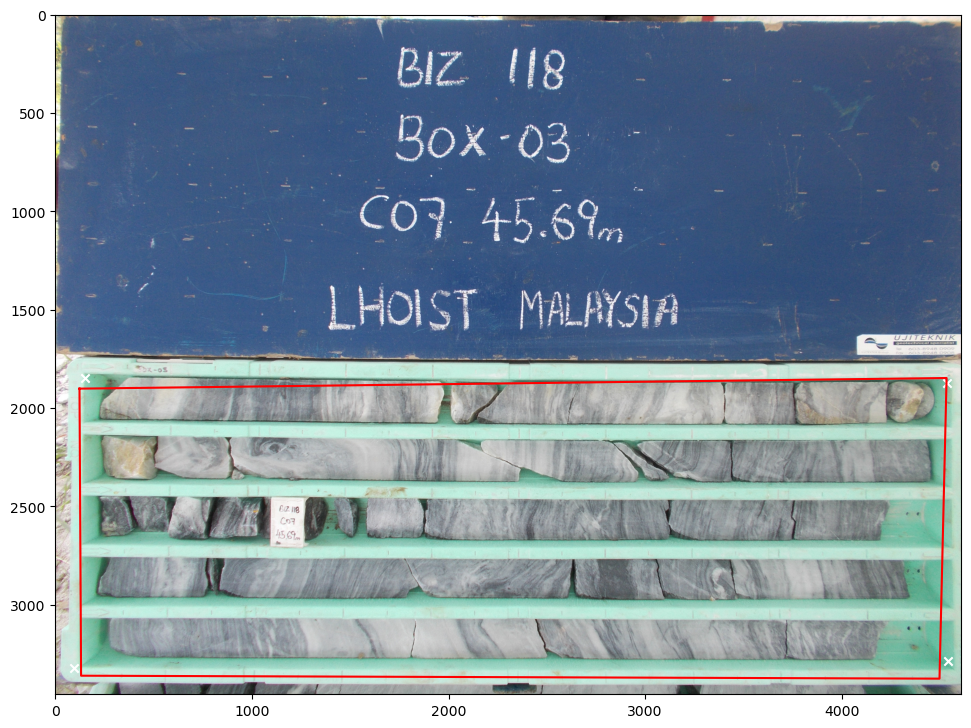

In [41]:
# display plot for every predicted image
for i in range(len(metadata)):
    # create matplotlib figure
    fig, ax = plt.subplots(figsize=(16, 9), dpi=100)
    image = img.imread(metadata['fullname'][i])

    # plot image
    plt.imshow(image)

    # plot red box with predicted coordinates
    plt.plot(predicted[0][['p1x', 'p2x', 'p3x', 'p4x', 'p1x']].iloc[i], predicted[0][[
             'p1y', 'p2y', 'p3y', 'p4y', 'p1y']].iloc[i], color='r')

    # plot white crosses with labeled values
    plt.scatter(predicted[1][['p1x', 'p2x', 'p3x', 'p4x']].iloc[i], predicted[1][[
                'p1y', 'p2y', 'p3y', 'p4y']].iloc[i], color='white', marker='x')

    # print predictions and true labels
    print(
        f'--------Predicted--------\n{predicted[0].iloc[i]}\n--------True--------\n{predicted[1].iloc[i]}')

    # show figure
    plt.show()

    # Clear output and create new figure after ten seconds
    time.sleep(10)
    clear_output(wait=True)
